In [1]:
!pip install arch

You should consider upgrading via the '/Users/timofejvilkov/Documents/GitHub/SmartMed/.venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import sys
sys.path.append("./.venv/lib/python3.8/site-packages")
import numpy as np
import pandas as pd
import scipy.integrate as integrate 
import scipy.stats as ss
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

sys.path.append("./ml/lib/python3.8/site-packages")
from arch import arch_model 

In [3]:
prices_new = yf.download('^NDX', '2010-01-01', '2017-12-31')
prices_new

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,1881.709961,1882.459961,1860.310059,1860.310059,1860.310059,1237820000
2010-01-04,1882.689941,1890.020020,1881.630005,1886.699951,1886.699951,1931380000
2010-01-05,1887.280029,1891.329956,1877.520020,1888.430054,1888.430054,2367860000
2010-01-06,1887.910034,1893.209961,1873.900024,1878.420044,1878.420044,2253340000
2010-01-07,1878.160034,1881.329956,1867.619995,1876.719971,1876.719971,2270050000
...,...,...,...,...,...,...
2017-12-22,6462.549805,6467.830078,6449.000000,6465.169922,6465.169922,1539250000
2017-12-26,6427.319824,6438.240234,6407.990234,6433.160156,6433.160156,1304340000
2017-12-27,6437.060059,6448.939941,6425.919922,6435.149902,6435.149902,1409540000


### Returns Plot

<AxesSubplot:xlabel='Date'>

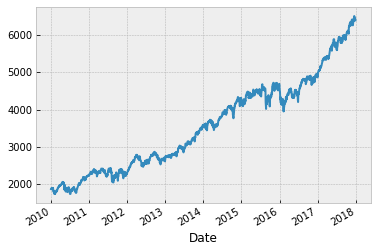

In [4]:
price_new = prices_new['Adj Close']

price_new.head()

dX = price_new.diff()

ret_log = np.log(price_new).diff()

ret_new = price_new.pct_change()

ret_new = ret_new.dropna()

prices_new.index = prices_new.index.to_period(freq='d')

price_new.plot()

### Using the ARMA and EGARCH(2, 2, 2) models for getting filtered residiuals

In [5]:

alpha = 0.5

# fit the model with normal ditribution
mdl_new = arch_model(100 * ret_new,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='EGARCH', p=2, o=2, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='t')

res_new = mdl_new.fit(disp='off')



# get Standartized residuals
stand_residuals = res_new.resid / res_new.conditional_volatility
stand_residuals = stand_residuals.dropna()


# forecast mean and variance one step ahead
forecasts = res_new.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])


# conditional forecats return
conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
conditional_sr = conditional_sr / 100



res_new

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    Adj Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -2632.29
Distribution:      Standardized Student's t   AIC:                           5282.58
Method:                  Maximum Likelihood   BIC:                           5333.04
                                              No. Observations:                 2013
Date:                      Fri, Oct 02 2020   Df Residuals:                     2004
Time:                              21:58:51   Df Model:                            9
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### Move from returns to prices 

In [6]:
filt_prices_new = [price_new[1]]
for ret in conditional_sr.values:
    filt_prices_new.append(filt_prices_new[-1] * ret + filt_prices_new[-1] )

filt_prices_new = pd.DataFrame({'Date': price_new.index, 'filt_price': filt_prices_new})
filt_prices_new = filt_prices_new.sort_values('Date').set_index('Date')

<Figure size 1080x720 with 0 Axes>

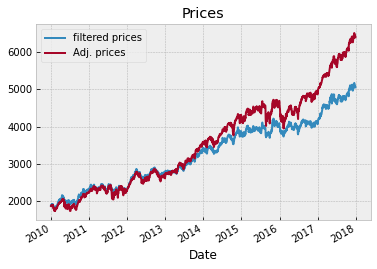

In [7]:
fig = plt.figure(figsize=(15, 10))
filt_prices_new.plot()
price_new.plot()
plt.title("Prices")
plt.legend(['filtered prices', 'Adj. prices'])

### Strategy realisation: SMA Crossover

In [8]:
def strategy(prices_new, short_window, long_window):
# Initialize the short and long windows
#Initialize the signals DataFrame with the signal column
    signals = pd.DataFrame(index=prices_new.index)
    signals['signal'] = 0.0

#Create short simple moving average over the short window
    signals['short_mavg'] = prices_new['Adj Close'].rolling(window=short_window, min_periods=1, center=False).mean()

#Create long simple moving average over the long window
    signals['long_mavg'] = prices_new['Adj Close'].rolling(window=long_window, min_periods=1, center=False).mean()
# Create signals
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

#Generate trading orders
    signals['positions'] = signals['signal'].diff()
    
    return signals
    
    


In [9]:
signals = strategy(prices_new, 20, 220)
prices_new['Position'] = signals['signal']

In [10]:
def comulative_returns(prices_new):
    prices_new['Market Return1'] = None
    prices_new['Strategy Return'] = None
    for row in range(len(prices_new)):
        prices_new['Market Return1'].iloc[row] = (prices_new['Adj Close'].iloc[row]-prices_new['Adj Close'].iloc[row-1])/prices_new['Adj Close'].iloc[row-1]
        prices_new['Strategy Return'].iloc[row] = prices_new['Market Return1'].iloc[row]*prices_new['Position'].iloc[row-1]
        if prices_new['Position'].iloc[row-1] == 0 and prices_new['Position'].iloc[row] != 0:
            prices_new['Strategy Return'].iloc[row] = prices_new['Market Return1'].iloc[row]*prices_new['Position'].iloc[row-1]  - 0.001
        else:
            prices_new['Strategy Return'].iloc[row] = prices_new['Market Return1'].iloc[row]*prices_new['Position'].iloc[row-1]
    prices_new['Market Return1'].iloc[0]=0
    prices_new['Strategy Return'].iloc[0]=0

    return prices_new['Strategy Return'].cumsum()

In [11]:
    
result = comulative_returns(prices_new)

### Indicators for shorts and longs

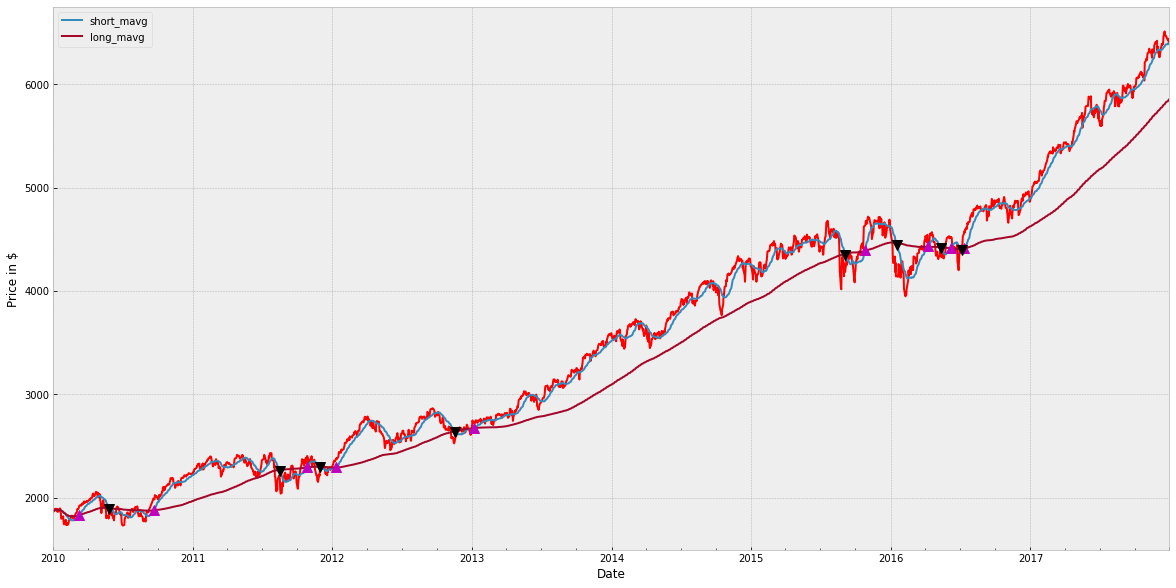

In [12]:
fig = plt.figure(figsize=(20, 10))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
prices_new['Adj Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, signals.short_mavg[signals.positions == 1.0], '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, signals.short_mavg[signals.positions == -1.0], 'v', markersize=10, color='k')

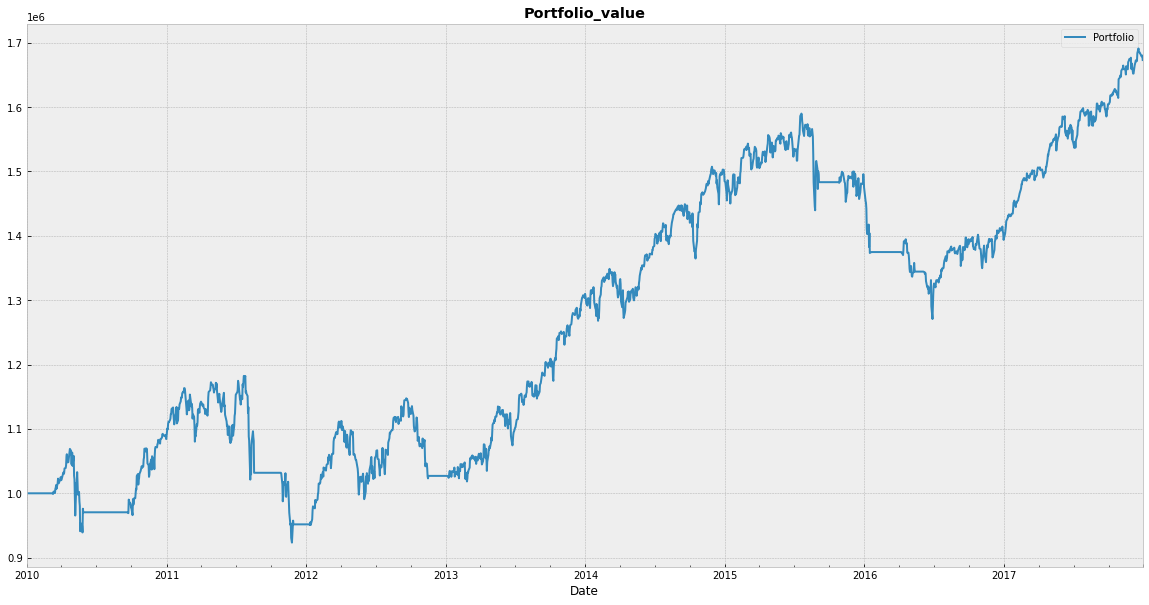

In [13]:
fig = plt.figure(figsize=(20, 10))
result = (1 + result)*1000000
result.plot()
plt.title("Portfolio_value", weight="bold")
plt.legend(['Portfolio'])

### Fitting model

In [14]:
short_ma = np.linspace(10,60,25,dtype=int)
long_ma = np.linspace(150,252,25,dtype=int)

In [15]:
results_pnl = np.zeros((len(short_ma),len(long_ma)))
results_sharpe = np.zeros((len(short_ma),len(long_ma)))

In [16]:
def annualised_sharpe(returns, N=2014):
    return np.sqrt(N) * (returns.mean() / returns.std())

In [17]:
def fitting_model(short_window, long_window):
    # Initialize the short and long windows
#Initialize the signals DataFrame with the signal column
    signals = pd.DataFrame(index=prices_new.index)
    signals['signal'] = 0.0

#Create short simple moving average over the short window
    signals['short_mavg'] = prices_new['Adj Close'].rolling(window=short_window, min_periods=1, center=False).mean()

#Create long simple moving average over the long window
    signals['long_mavg'] = prices_new['Adj Close'].rolling(window=long_window, min_periods=1, center=False).mean()
# Create signals
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

#Generate trading orders
    signals['positions'] = signals['signal'].diff()
    
    df = pd.DataFrame()
    df['Position'] = signals['signal']
    df['Market Return1'] = None
    df['Strategy Return'] = None
    for row in range(len(df)):
        df['Market Return1'].iloc[row] = (prices_new['Adj Close'].iloc[row]-prices_new['Adj Close'].iloc[row-1])/prices_new['Adj Close'].iloc[row-1]
        df['Strategy Return'].iloc[row] = df['Market Return1'].iloc[row]*df['Position'].iloc[row-1]
        if df['Position'].iloc[row-1] == 0 and df['Position'].iloc[row] != 0:
            df['Strategy Return'].iloc[row] = df['Market Return1'].iloc[row]*df['Position'].iloc[row-1]  - 0.001
        else:
            df['Strategy Return'].iloc[row] = df['Market Return1'].iloc[row]*df['Position'].iloc[row-1]
    df['Market Return1'].iloc[0]=0
    df['Strategy Return'].iloc[0]=0
    sharpe = annualised_sharpe(df['Strategy Return'])
    return (df['Strategy Return'].cumsum()[-1], sharpe)
    

In [18]:
gachi, sha = fitting_model(30, 250)
sha

2.037395280908684

In [19]:
for i, shortma in enumerate(short_ma):
    for j, longma in enumerate(long_ma):
        pnl, sharpe = fitting_model(shortma,longma)
        results_pnl[i,j] = pnl
        results_sharpe[i,j] = sharpe
        print(i, j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
6 24
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
7 20
7 21
7 22
7 23
7 24
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17


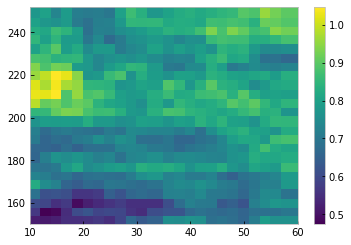

In [20]:
plt.pcolor(short_ma,long_ma,results_pnl)
plt.colorbar()
plt.show()

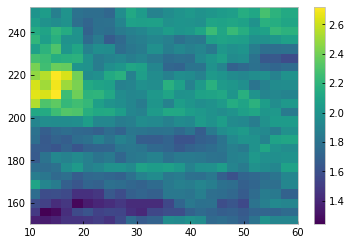

In [21]:
plt.pcolor(short_ma,long_ma,results_sharpe)
plt.colorbar()
plt.show()

### VaR and ES (t - student) for Market Prices

In [22]:
alpha = 0.5

params_t = ss.t.fit(ret_new)
t_df, t_mean, t_sigma = params_t

VaR_t = ss.t.ppf(alpha, t_df, t_mean, t_sigma)
ES_t = ss.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: df=3.21, mean=0.00, scale=0.01
Value-at-Risk: 0.10%
Expected Shortfall: -0.65%


<AxesSubplot:xlabel='Date'>

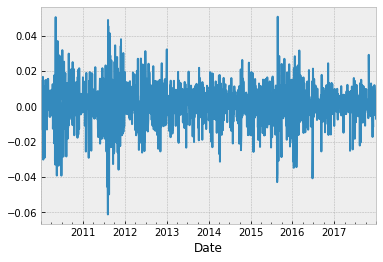

In [23]:
price_new = prices_new['Adj Close']

price_new.head()

dX = price_new.diff()

ret_log = np.log(price_new).diff()

ret_new = price_new.pct_change()

ret_new = ret_new.dropna()



ret_new.plot()

<AxesSubplot:xlabel='Date'>

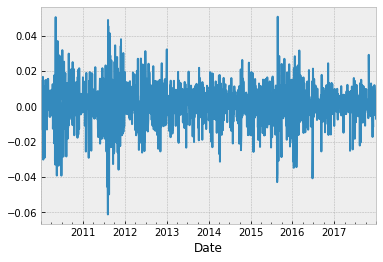

In [25]:
ret_for_var = prices_new['Strategy Return']

ret_for_var = ret_new.dropna()


ret_for_var.plot()

In [26]:
alpha = 0.5

params_t_1 = ss.t.fit(ret_for_var)
t_df_1, t_mean_1, t_sigma_1 = params_t_1

VaR_t_1 = ss.t.ppf(alpha, t_df_1, t_mean_1, t_sigma_1)
ES_t_1 = ss.t.expect(args=(t_df,), loc=t_mean_1, scale=t_sigma_1, ub=VaR_t_1, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df_1, t_mean_1, t_sigma_1))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t_1))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t_1))

Estimated parameters: df=3.21, mean=0.00, scale=0.01
Value-at-Risk: 0.10%
Expected Shortfall: -0.65%


### Max dd for one week

In [27]:
window = 7
rolling_max = prices_new['Strategy Return'].rolling(window, min_periods=1).max()
rolling_min = prices_new['Strategy Return'].rolling(window, min_periods=1).min()
daily_drawdown = rolling_max-rolling_min
daily_drawdown.max()

0.10988557018374118

### Max dd per day

In [28]:
window = 2
rolling_max = prices_new['Strategy Return'].rolling(window, min_periods=1).max()
rolling_min = prices_new['Strategy Return'].rolling(window, min_periods=1).min()
daily_drawdown = rolling_max-rolling_min
daily_drawdown.max()

0.10988557018374118

In [62]:
ret = prices_new['Strategy Return'] 
Rachev_ratio = -1*integrate.quad(ret.quantile, 0.95, 1)[0]/ integrate.quad(ret.quantile, 0, 0.05)[0]
Rachev_ratio

0.8655802498897521

#### They are simular cause of very small quantity of offers

# Next step is backtest on testing set(18 - 19)

In [29]:
prices_new_1 = yf.download('^NDX', '2018-01-01', '2018-12-31')
prices_new_1

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,6431.589844,6513.020020,6417.750000,6511.339844,6511.339844,1914930000
2018-01-03,6520.029785,6579.250000,6519.259766,6575.799805,6575.799805,2166780000
2018-01-04,6595.750000,6603.169922,6576.919922,6584.580078,6584.580078,2098890000
2018-01-05,6613.129883,6654.979980,6605.029785,6653.290039,6653.290039,2020900000
2018-01-08,6651.680176,6680.319824,6649.200195,6676.629883,6676.629883,2051430000
...,...,...,...,...,...,...
2018-12-21,6293.049805,6308.310059,6013.979980,6046.560059,6046.560059,4534120000
2018-12-24,5994.080078,6075.169922,5895.120117,5899.350098,5899.350098,1647270000
2018-12-26,5969.080078,6263.819824,5921.859863,6262.770020,6262.770020,2557940000


<AxesSubplot:xlabel='Date'>

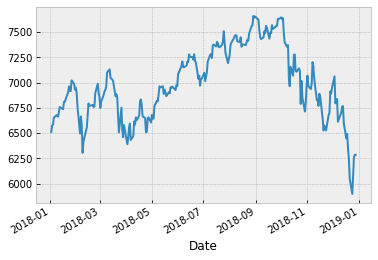

In [30]:
price_new_1 = prices_new_1['Adj Close']

ret_new_1 = price_new_1.pct_change()

ret_new_1 = ret_new_1.dropna()


price_new_1.plot()

In [31]:
alpha = 0.5

# fit the model with normal ditribution
mdl_new_1 = arch_model(100 * ret_new_1,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='EGARCH', p=2, o=2, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='t')

res_new_1 = mdl_new_1.fit(disp='off')



# get Standartized residuals
stand_residuals_1 = res_new_1.resid / res_new_1.conditional_volatility
stand_residuals_1 = stand_residuals_1.dropna()


# forecast mean and variance one step ahead
forecasts_1 = res_new_1.forecast(horizon=1)
cond_mean_1 = float(forecasts_1.mean.iloc[-1])
cond_var_1 = float(forecasts_1.variance.iloc[-1])


# conditional forecats return
conditional_sr_1 = cond_mean_1 + np.sqrt(cond_var_1) * stand_residuals_1
conditional_sr_1 = conditional_sr_1 / 100



res_new_1

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    Adj Close   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                           EGARCH   Log-Likelihood:               -398.792
Distribution:      Standardized Student's t   AIC:                           815.584
Method:                  Maximum Likelihood   BIC:                           847.241
                                              No. Observations:                  249
Date:                      Fri, Oct 02 2020   Df Residuals:                      240
Time:                              22:10:26   Df Model:                            9
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

In [32]:
filt_prices_new_1 = [price_new_1[1]]
for ret in conditional_sr_1.values:
    filt_prices_new_1.append(filt_prices_new_1[-1] * ret + filt_prices_new_1[-1] )

filt_prices_new_1 = pd.DataFrame({'Date': price_new_1.index, 'filt_price': filt_prices_new_1})
filt_prices_new_1 = filt_prices_new_1.sort_values('Date').set_index('Date')

<Figure size 1080x720 with 0 Axes>

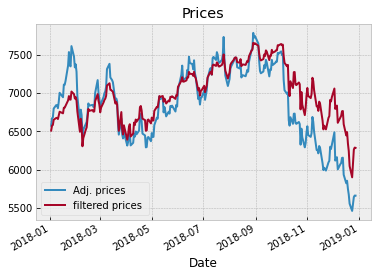

In [33]:
fig = plt.figure(figsize=(15, 10))
filt_prices_new_1.plot()
price_new_1.plot()
plt.title("Prices")
plt.legend(['Adj. prices', 'filtered prices '])

In [34]:
signals_1 = strategy(prices_new_1, 20, 220)
prices_new_1['Position'] = signals_1['signal']

In [35]:
result_1 = comulative_returns(prices_new_1)

<AxesSubplot:xlabel='Date'>

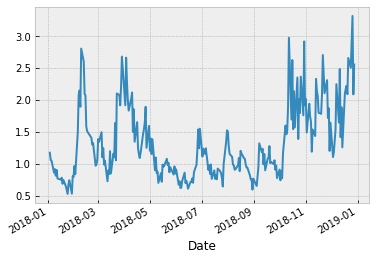

In [36]:
res_new_1.conditional_volatility.plot()

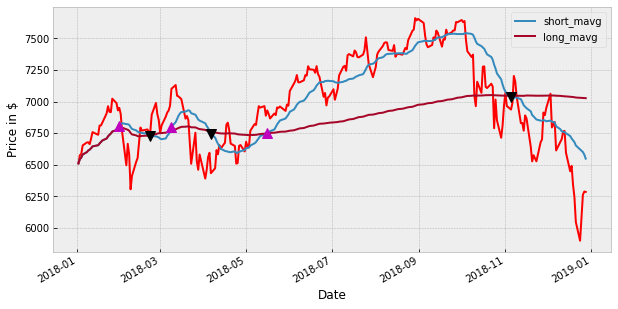

In [37]:
fig = plt.figure(figsize=(10, 5))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
prices_new_1['Adj Close'].plot(ax=ax1, color='r', lw=2.)


# Plot the short and long moving averages
signals_1[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals_1.loc[signals_1.positions == 1.0].index, signals_1.short_mavg[signals_1.positions == 1.0], '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals_1.loc[signals_1.positions == -1.0].index, signals_1.short_mavg[signals_1.positions == -1.0], 'v', markersize=10, color='k')

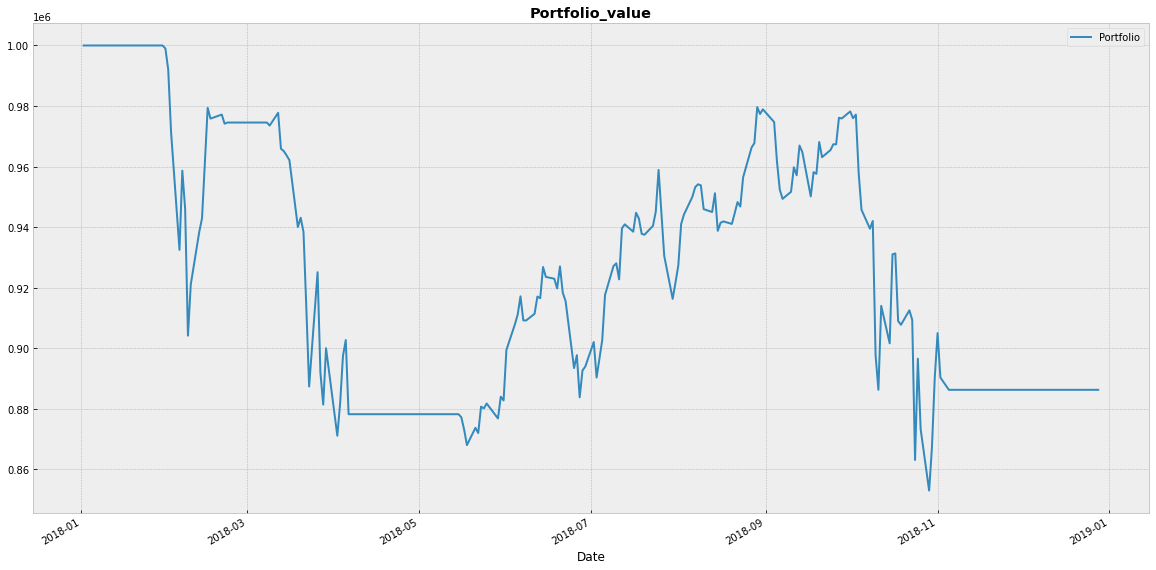

In [38]:
fig = plt.figure(figsize=(20, 10))
result_1 = (1 + result_1)*1000000
result_1.plot()
plt.title("Portfolio_value", weight="bold")
plt.legend(['Portfolio'])

In [39]:
alpha = 0.5

params_t = ss.t.fit(ret_new_1)
t_df, t_mean, t_sigma = params_t

VaR_t = ss.t.ppf(alpha, t_df, t_mean, t_sigma)
ES_t = ss.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: df=3.17, mean=0.00, scale=0.01
Value-at-Risk: 0.10%
Expected Shortfall: -0.95%


<AxesSubplot:xlabel='Date'>

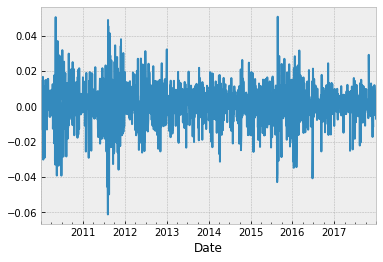

In [42]:
ret_for_var_1 = prices_new['Strategy Return']

ret_for_var_1 = ret_new.dropna()


ret_for_var_1.plot()

In [43]:
alpha = 0.5

params_t_1 = ss.t.fit(ret_for_var_1)
t_df_1, t_mean_1, t_sigma_1 = params_t_1

VaR_t_1 = ss.t.ppf(alpha, t_df_1, t_mean_1, t_sigma_1)
ES_t_1 = ss.t.expect(args=(t_df,), loc=t_mean_1, scale=t_sigma_1, ub=VaR_t_1, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df_1, t_mean_1, t_sigma_1))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t_1))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t_1))

Estimated parameters: df=3.21, mean=0.00, scale=0.01
Value-at-Risk: 0.10%
Expected Shortfall: -0.66%


In [44]:
window = 7
rolling_max = prices_new_1['Strategy Return'].rolling(window, min_periods=1).max()
rolling_min = prices_new_1['Strategy Return'].rolling(window, min_periods=1).min()
daily_drawdown = rolling_max-rolling_min
daily_drawdown.max()

0.07976063699197494

In [45]:
annualised_sharpe(prices_new_1['Strategy Return'])

-1.9055486446054009

In [61]:
ret = prices_new_1['Strategy Return'] 
Rachev_ratio = -1*integrate.quad(ret.quantile, 0.95, 1)[0]/ integrate.quad(ret.quantile, 0, 0.05)[0]
Rachev_ratio

0.7486981151570007

In [46]:
prices_new_2 = yf.download('^NDX', '2019-01-01', '2020-12-31')
prices_new_2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,6354.850098,6365.390137,6273.939941,6329.970215,6329.970215,2098560000
2019-01-02,6198.680176,6394.740234,6198.680176,6360.870117,6360.870117,2261800000
2019-01-03,6274.759766,6292.680176,6139.399902,6147.129883,6147.129883,2607290000
2019-01-04,6250.049805,6445.200195,6234.589844,6422.669922,6422.669922,2579550000
2019-01-07,6434.549805,6521.439941,6412.979980,6488.250000,6488.250000,2507550000
...,...,...,...,...,...,...
2020-09-28,11332.320312,11369.400391,11243.240234,11364.450195,11364.450195,3562900000
2020-09-29,11354.700195,11396.219727,11305.790039,11322.950195,11322.950195,3363870000
2020-09-30,11328.549805,11535.009766,11328.549805,11418.059570,11418.059570,4228200000


<AxesSubplot:xlabel='Date'>

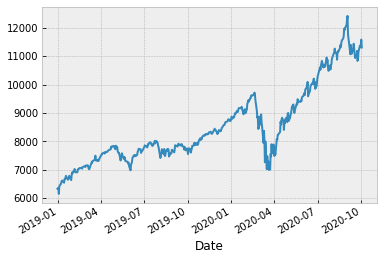

In [74]:
price_new_2 = prices_new_2['Adj Close']

ret_new_2 = price_new_2.pct_change()

ret_new_2 = ret_new_2.dropna()


price_new_2.plot()

In [48]:
alpha = 0.5

# fit the model with normal ditribution
mdl_new_2 = arch_model(100 * ret_new_2,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='EGARCH', p=2, o=2, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='t')

res_new_2 = mdl_new_2.fit(disp='off')



# get Standartized residuals
stand_residuals_2 = res_new_2.resid / res_new_2.conditional_volatility
stand_residuals_2 = stand_residuals_2.dropna()


# forecast mean and variance one step ahead
forecasts_2 = res_new_2.forecast(horizon=1)
cond_mean_2 = float(forecasts_2.mean.iloc[-1])
cond_var_2 = float(forecasts_2.variance.iloc[-1])


# conditional forecats return
conditional_sr_2 = cond_mean_2 + np.sqrt(cond_var_2) * stand_residuals_2
conditional_sr_2 = conditional_sr_2 / 100



res_new_2

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    Adj Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -727.671
Distribution:      Standardized Student's t   AIC:                           1473.34
Method:                  Maximum Likelihood   BIC:                           1510.19
                                              No. Observations:                  443
Date:                      Fri, Oct 02 2020   Df Residuals:                      434
Time:                              22:10:39   Df Model:                            9
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [49]:
filt_prices_new_2 = [price_new_2[1]]
for ret in conditional_sr_2.values:
    filt_prices_new_2.append(filt_prices_new_2[-1] * ret + filt_prices_new_2[-1] )

filt_prices_new_2 = pd.DataFrame({'Date': price_new_2.index, 'filt_price': filt_prices_new_2})
filt_prices_new_2 = filt_prices_new_2.sort_values('Date').set_index('Date')

<Figure size 1080x720 with 0 Axes>

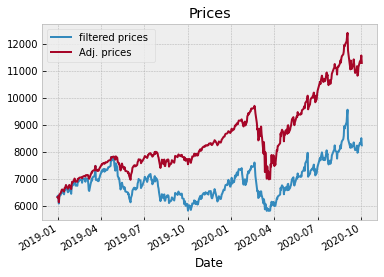

In [50]:
fig = plt.figure(figsize=(15, 10))
filt_prices_new_2.plot()
price_new_2.plot()
plt.title("Prices")
plt.legend(['filtered prices ', 'Adj. prices'])

In [51]:
signals_2 = strategy(prices_new_2, 20, 220)
prices_new_2['Position'] = signals_2['signal']

In [52]:
result_2 = comulative_returns(prices_new_2)

<AxesSubplot:xlabel='Date'>

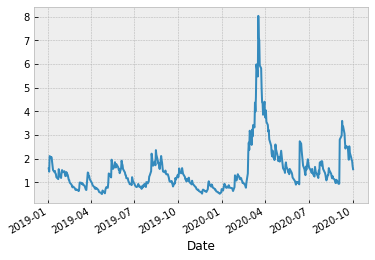

In [53]:
res_new_2.conditional_volatility.plot()

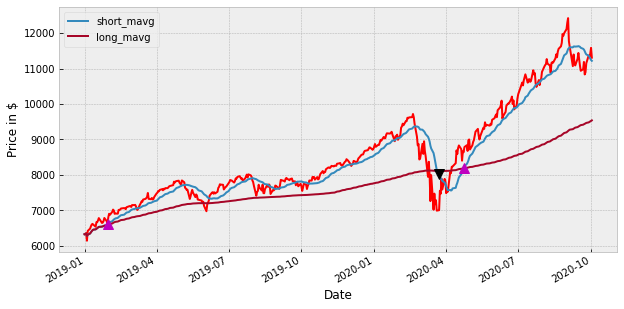

In [54]:
fig = plt.figure(figsize=(10, 5))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
prices_new_2['Adj Close'].plot(ax=ax1, color='r', lw=2.)


# Plot the short and long moving averages
signals_2[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals_2.loc[signals_2.positions == 1.0].index, signals_2.short_mavg[signals_2.positions == 1.0], '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals_2.loc[signals_2.positions == -1.0].index, signals_2.short_mavg[signals_2.positions == -1.0], 'v', markersize=10, color='k')

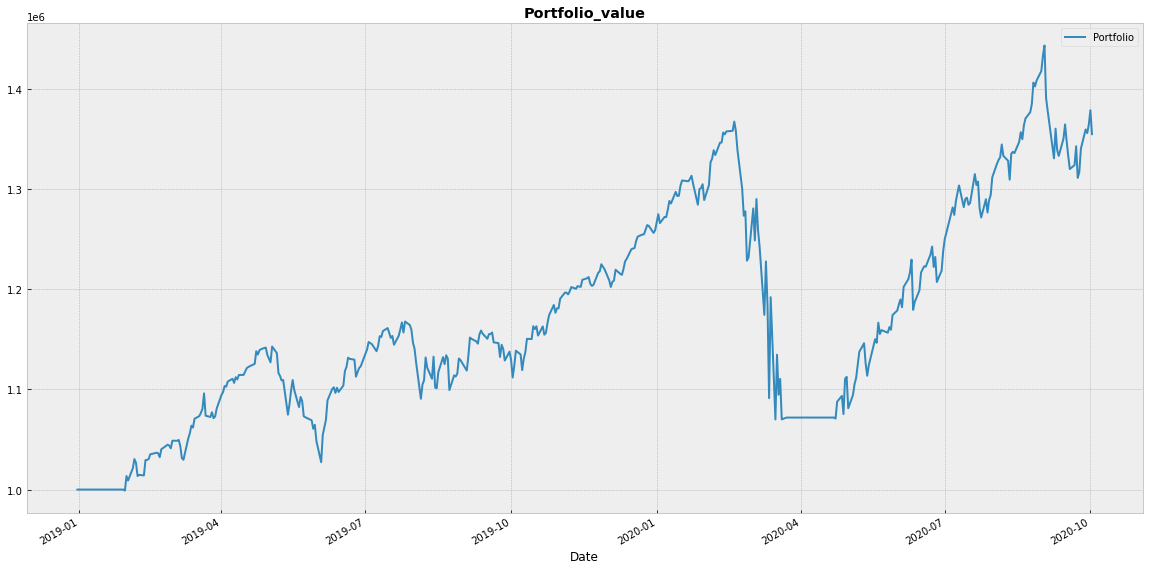

In [55]:
fig = plt.figure(figsize=(20, 10))
result_2 = (1 + result_2)*1000000
result_2.plot()
plt.title("Portfolio_value", weight="bold")
plt.legend(['Portfolio'])

In [100]:
alpha = 0.05

params_t = ss.t.fit(ret_new_2)
t_df, t_mean, t_sigma = params_t

VaR_t = ss.t.ppf(alpha, t_df, t_mean, t_sigma)
ES_t = ss.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: df=2.14, mean=0.00, scale=0.01
Value-at-Risk: -2.19%
Expected Shortfall: -4.66%


<AxesSubplot:xlabel='Date'>

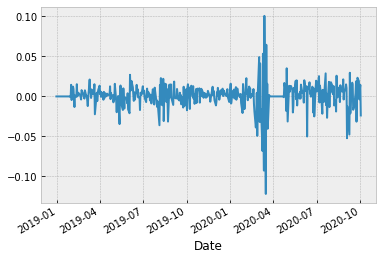

In [57]:
ret_for_var_2 = prices_new_2['Strategy Return']

ret_for_var_2 = ret_for_var_2.dropna()

ret_for_var_2.plot()

In [58]:
window = 7
rolling_max = prices_new_2['Strategy Return'].rolling(window, min_periods=1).max()
rolling_min = prices_new_2['Strategy Return'].rolling(window, min_periods=1).min()
daily_drawdown = rolling_max-rolling_min
daily_drawdown.max()

0.2226543050611745

In [80]:
ret = prices_new_2['Strategy Return'] 
Rachev_ratio = -1*integrate.quad(ret.quantile, 0.95, 1)[0]/ integrate.quad(ret.quantile, 0, 0.05)[0]
Rachev_ratio

0.7209774946590289

In [92]:
result_2[-1]

1354659.069181135

In [97]:
135.4659/daily_drawdown.max()

608.4135672237759

In [99]:
ret_new_2

Date
2019-01-02    0.004882
2019-01-03   -0.033602
2019-01-04    0.044824
2019-01-07    0.010211
2019-01-08    0.009802
                ...   
2020-09-28    0.019130
2020-09-29   -0.003652
2020-09-30    0.008400
2020-10-01    0.014463
2020-10-02   -0.023849
Name: Adj Close, Length: 443, dtype: float64